In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Cargar los datos
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Preprocesar los datos
# Codificar variables categóricas
label_encoder = LabelEncoder()
data['weather_type'] = label_encoder.fit_transform(data['weather_type'])
# data['cloud_cover'] = label_encoder.fit_transform(data['cloud_cover'])
# data['season'] = label_encoder.fit_transform(data['season'])
# data['location'] = label_encoder.fit_transform(data['location'])

# Do dummies for categorical variables
data = pd.get_dummies(data, columns=['location', 'season', 'cloud_cover'])

target = 'weather_type'

# Mostrar la correlación entre las características y el objetivo
correlation = data.corr()
print(correlation[target].sort_values(ascending=False))

weather_type                 1.000000
cloud_cover_clear            0.589990
uv_index                     0.345804
season_Winter                0.135562
visibility_(km)              0.047448
location_mountain            0.045542
atmospheric_pressure         0.030679
temperature                  0.028923
location_inland              0.026744
cloud_cover_cloudy           0.009168
season_Summer               -0.045884
season_Autumn               -0.056896
season_Spring               -0.067318
location_coastal            -0.078325
precipitation_(%)           -0.161578
wind_speed                  -0.166485
cloud_cover_partly cloudy   -0.224718
cloud_cover_overcast        -0.224957
humidity                    -0.250558
Name: weather_type, dtype: float64


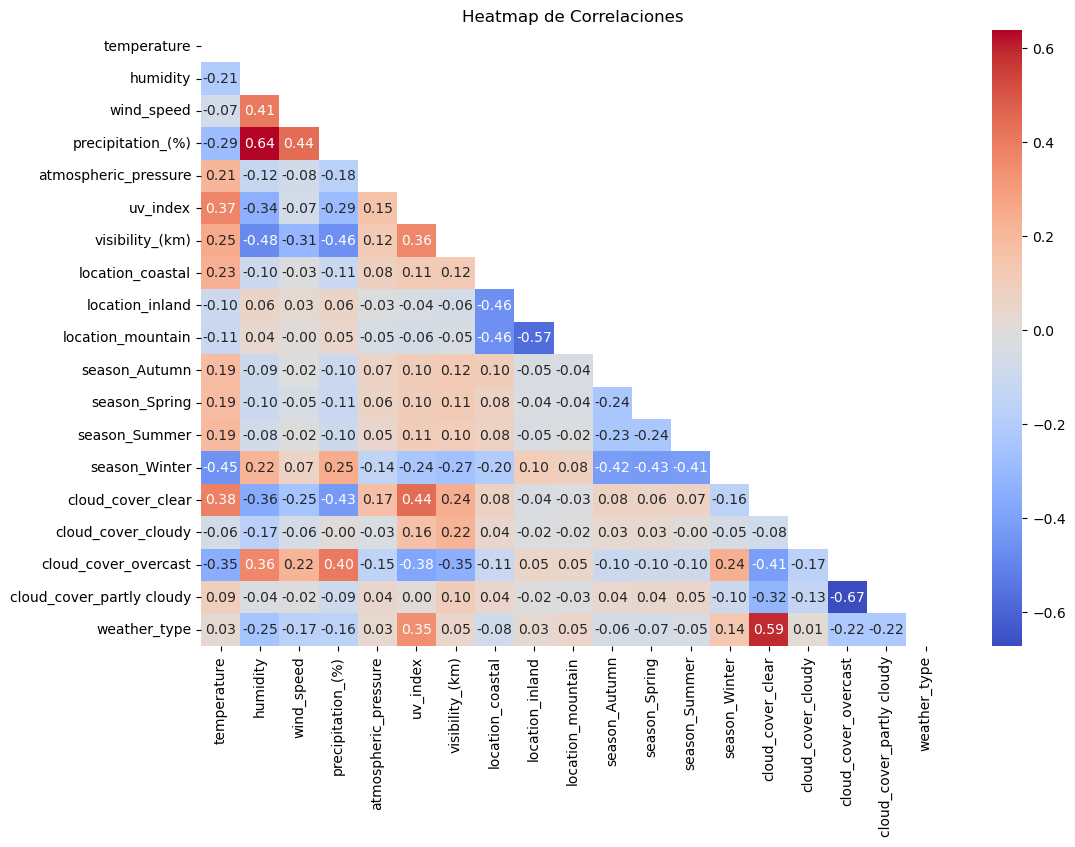

In [71]:
# Reorganizar las columnas para que la variable objetivo esté al final
columns = [col for col in correlation.columns if col != target] + [target]
correlation = correlation[columns].loc[columns]

# Visualizar el heatmap de correlaciones
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Heatmap de Correlaciones')
plt.show()

In [67]:
# Separar características y etiquetas
X = data.drop(target, axis=1)
y = data[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_standarized = scaler.fit_transform(X_train)
X_test_standarized = scaler.transform(X_test)

# Ajustar los parámetros del Random Forest
param_grid = {
    'n_estimators': [15, 20],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# param_grid = {
#     'n_estimators': [150, 200],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [15, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'bootstrap': [True, False]
# }

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_standarized, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_clf = RandomForestClassifier(**best_params)
rnd_clf.fit(X_train_standarized, y_train)

# Predecir
y_pred = rnd_clf.predict(X_test_standarized)

# Evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Best Parameters: {best_params}')

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
109 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-packag

Accuracy: 0.9106060606060606
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}


In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       651
           1       0.91      0.90      0.91       647
           2       0.93      0.94      0.94       701
           3       0.93      0.91      0.92       641

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



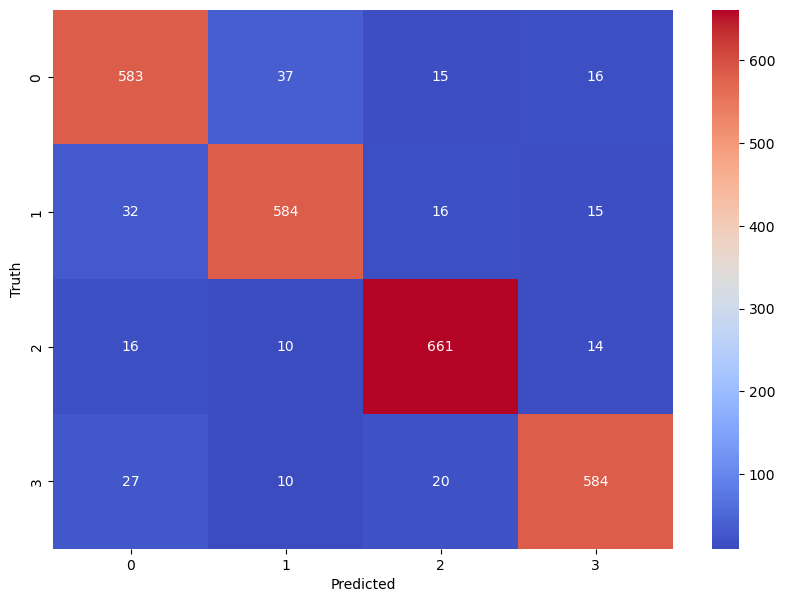

In [59]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


## Con métricas reales de estación meteorológica (con estandarización)

In [60]:
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Drop meaningless columns
data = data.drop(['season', 'location', 'cloud_cover'], axis=1)

# Separar características y etiquetas
X = data.drop('weather_type', axis=1)
y = data['weather_type']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_standarized = scaler.fit_transform(X_train)
X_test_standarized = scaler.transform(X_test)

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_standarized, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_clf = RandomForestClassifier(**best_params)
rnd_clf.fit(X_train_standarized, y_train)

# Predecir
y_pred = rnd_clf.predict(X_test_standarized)

# Evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Best Parameters: {best_params}')

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
113 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-packag

Accuracy: 0.9071969696969697
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}


## Con métricas reales de estación meteorológica (con normalización)

In [61]:
# Load the data
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Drop meaningless columns
# data = data.drop(['season', 'location', 'cloud_cover'], axis=1)
data = data.drop(['cloud_cover'], axis=1)

# Do dummies for season and location
data = pd.get_dummies(data, columns=['season', 'location'])

# Separar características y etiquetas
X = data.drop('weather_type', axis=1)
y = data['weather_type']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_normalized, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_clf = RandomForestClassifier(**best_params)
rnd_clf.fit(X_train_normalized, y_train)

# Predecir
y_pred = rnd_clf.predict(X_test_normalized)

# Evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Best Parameters: {best_params}')

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-package

Accuracy: 0.9041666666666667
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


## The ROC Curve

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
107 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-packag

Accuracy: 0.9022727272727272
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}


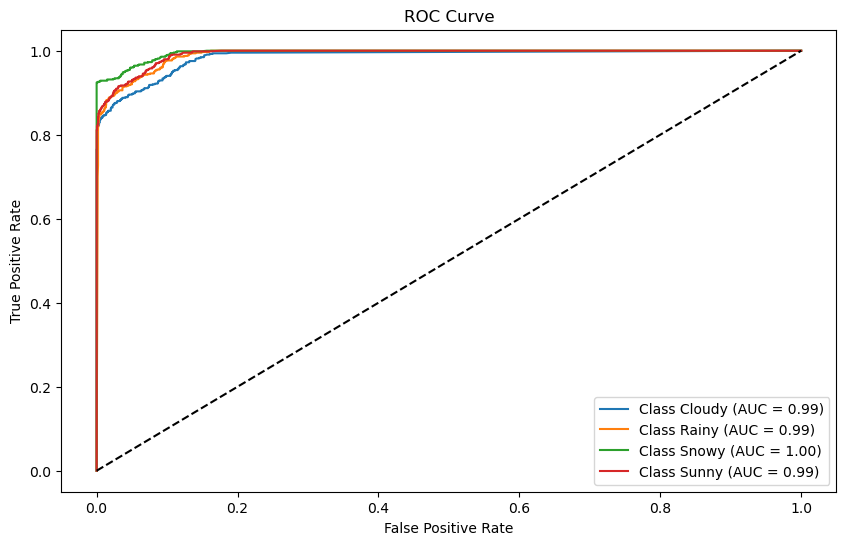

In [62]:
# Load the data
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Drop meaningless columns
data = data.drop(['season', 'location', 'cloud_cover'], axis=1)

# Separar características y etiquetas
X = data.drop('weather_type', axis=1)
y = data['weather_type']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_normalized, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_clf = RandomForestClassifier(**best_params)
rnd_clf.fit(X_train_normalized, y_train)

# Predecir
y_pred = rnd_clf.predict(X_test_normalized)

# Evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Best Parameters: {best_params}')

# Binarizar las etiquetas para calcular la ROC Curve para cada clase
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
y_prob = rnd_clf.predict_proba(X_test_normalized)

# Calcular y graficar la ROC Curve para cada clase
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()